In [1]:
import os 
os.chdir('../../')
os.environ["DPM_TQDM"] = "False"

In [2]:
from backbones.dit import DiT

# 사용 예
model = DiT(trainable=True)
print(model)

/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch /home/scpark/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae: Error no file named diffusion_pytorch_model.safetensors found in directo

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_class_images(pixel_samples, class_ids=None, figsize_per_image=1.5, display_title=""):
    samples = list(pixel_samples)
    processed = []
    for img in samples:
        if isinstance(img, Image.Image):
            arr = np.array(img)
        else:
            arr = np.array(img)
            if arr.ndim == 3 and arr.shape[0] in (1,3):
                arr = arr.transpose(1, 2, 0)
        processed.append(arr)

    n = len(processed)
    if class_ids is None:
        class_ids = list(range(n))

    fig, axes = plt.subplots(1, n, figsize=(n * figsize_per_image, figsize_per_image))
    if n == 1:
        axes = [axes]

    # 전체 제목 추가
    if display_title:
        fig.suptitle(display_title, fontsize=10, y=1.1)  # y 값을 1.02로 올려서 제목을 위로 이동
    # 플롯 레이아웃 조정: top을 낮춰서 제목과 플롯 사이에 공간 확보
    
    for ax, img_arr, lbl in zip(axes, processed, class_ids):
        ax.imshow(img_arr)
        ax.axis("off")
        ax.set_title(f"Class {lbl}", fontsize=8)

    plt.show()


In [4]:
import torch
import torch.nn.functional as F
from torch import amp
from solvers.dual.static.gdual_logaffine_solver import GDual_LogAffine_Solver

class_ids = [i for i in range(0, 1000, 10)][:8]
model_fn, noise_schedule, latents = model.get_model_fn(pos_conds=class_ids, guidance_scale=3.0)

print('done')

done


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:07<00:00, 26.62it/s]


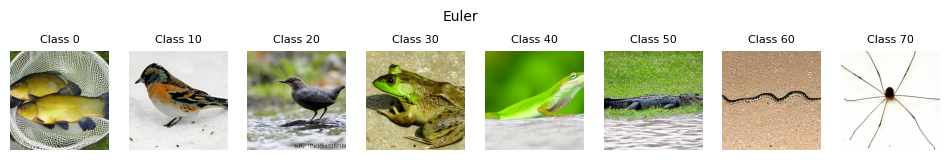

In [5]:
from solvers.euler_solver import Euler_Solver

with torch.no_grad():
    solver = Euler_Solver(model_fn, noise_schedule, algorithm_type="data_prediction")
    euler_latents = solver.sample(latents, steps=200, skip_type="time_uniform")
    euler_samples = model.decode_vae(euler_latents)
    display_class_images(euler_samples, class_ids, display_title='Euler')


/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


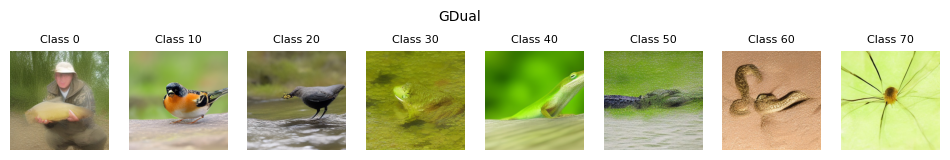

In [6]:

device = 'cuda:0'
#solver = GDual_LogAffine_Solver(model_fn, noise_schedule, steps=5, skip_type="time_uniform", param_dim=(4, 32, 32))
solver = GDual_LogAffine_Solver(model_fn, noise_schedule, steps=5, skip_type="time_uniform", param_dim=(4, 1, 1))
#solver = GDual_LogAffine_Solver(model_fn, noise_schedule, steps=5, skip_type="time_uniform", param_dim=())
solver = solver.to(device)

with torch.no_grad():
    gdual_latents = solver.sample(latents)
    gdual_samples = model.decode_vae(gdual_latents)
    display_class_images(gdual_samples, class_ids, display_title='GDual')


In [7]:
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-3)
scaler = amp.GradScaler()
print('done')

done


  0%|          | 0/1000 [00:00<?, ?it/s, loss=0.342]/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


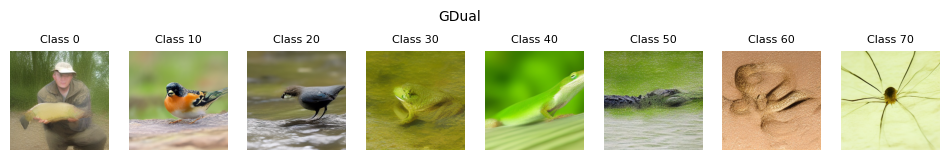

  7%|▋         | 68/1000 [01:37<22:22,  1.44s/it, loss=0.342]


KeyboardInterrupt: 

In [8]:
from tqdm import tqdm

pbar = tqdm(range(1000))
for iter in pbar:
    optimizer.zero_grad(set_to_none=True)
    with amp.autocast(device_type=device, dtype=torch.bfloat16):
        pr_latents = solver.sample(latents)
        loss = F.mse_loss(pr_latents, euler_latents)

        pbar.set_postfix({'loss': loss.item()})

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    if iter % 100 == 0:
        with torch.no_grad():
            pr_samples = model.decode_vae(pr_latents)
            display_class_images(pr_samples, class_ids, display_title='GDual')

print('done')